In [94]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.stats import binned_statistic
import h5py
import gc
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar


In [223]:
snapshot = 99
cvoxels = 1024  # child voxels
pvoxels = 32    # number of parent voxels
n_pvoxels = pvoxels
sim_boxsize = 205 # Mpc/h

sim_data = 'dark_matter_only'
data_dir = '/cosma7/data/dp004/dc-beck3/Dark2Light/data/%s/' % sim_data
sim_label = 'full_physics'
label_dir = '/cosma7/data/dp004/dc-beck3/Dark2Light/data/%s/' % sim_label

train_data_file = data_dir + '%s_s%d_v%d_dm_train.h5' % (sim_data, snapshot, cvoxels)
train_label_file = label_dir + '%s_s%d_v%d_st_train.h5' % (sim_label, snapshot, cvoxels)

valid_data_file = data_dir + '%s_s%d_v%d_dm_valid.h5' % (sim_data, snapshot, cvoxels)
valid_label_file = label_dir + '%s_s%d_v%d_st_valid.h5' % (sim_label, snapshot, cvoxels)

test_data_file = data_dir + '%s_s%d_v%d_dm_test.h5' % (sim_data, snapshot, cvoxels)
test_label_file = label_dir + '%s_s%d_v%d_st_test.h5' % (sim_label, snapshot, cvoxels)

In [51]:
# load train data

def load_data(pvoxels):
    content = np.zeros((len(pvoxels.keys()), 2))
    ii = 0
    for k, v in pvoxels.items():                                                   
        content[ii, 0] = np.count_nonzero(v)
        content[ii, 1] = np.sum(v)
        ii += 1
    return content

pvoxels = h5py.File(train_data_file, "r")
print(pvoxels["parent_x0_y0_z0"].shape)
train_data_content = load_data(pvoxels)
pvoxels = h5py.File(train_label_file, "r")
train_label_content = load_data(pvoxels)
train = {
    "data" : train_data_content,
    "label" : train_label_content,
}

pvoxels = h5py.File(valid_data_file, "r")
valid_data_content = load_data(pvoxels)
pvoxels = h5py.File(valid_label_file, "r")
valid_label_content = load_data(pvoxels)
valid = {
    "data" : valid_data_content,
    "label" : valid_label_content,
}

pvoxels = h5py.File(test_data_file, "r")
test_data_content = load_data(pvoxels)
pvoxels_test_data = pvoxels
pvoxels = h5py.File(test_label_file, "r")
test_label_content = load_data(pvoxels)
test = {
    "data" : test_data_content,
    "label" : test_label_content,
}
pvoxels_test_label = pvoxels
del pvoxels
gc.collect()

(32, 32, 32)


354

In [224]:
print(
    "If the simulation-box is devided into %d parent-voxels, " % (n_pvoxels) + \
    "the network would see a box with an edge-length of %.2f Mpc/h at a time" % (sim_boxsize/n_pvoxels))

If the simulation-box is devided into 32 parent-voxels, the network would see a box with an edge-length of 6.41 Mpc/h at a time


In [225]:
total_dm = np.sum(test["data"][:,1]) + np.sum(train["data"][:,1]) + np.sum(valid["data"][:,1])
total_stars = np.sum(test["label"][:,1]) + np.sum(train["label"][:,1]) + np.sum(valid["label"][:,1])
print(f'There are {total_dm:.2E} dark matter particles, and {total_stars:.2E} star particles')

There are 1.56E+10 dark matter particles, and 7.12E+08 star particles


In [226]:
print('PER VOXEL STATISTICS\n')
print(f'******************** TRAIN ********************')
print('Percentage of non-zero dark matter voxels:')
print(f'{100 * np.sum(train["data"][:,0])/(len(train["data"][:,0])*32*32*32):.2f} %')
print('Percentage of non-zero star voxels:')
print(f'{100 * np.sum(train["label"][:,0])/(len(train["label"][:,0])*32*32*32):.2f} % \n')

print(f'******************** TEST ********************')
print('Percentage of non-zero dark matter voxels:')
print(f'{100 * np.sum(test["data"][:,0])/(len(test["data"][:,0])*32*32*32):.2f} %')
print('Percentage of non-zero star voxels:')
print(f'{100 * np.sum(test["label"][:,0])/(len(test["label"][:,0])*32*32*32):.2f} % \n')

print(f'******************** VAL ********************')
print('Percentage of non-zero dark matter voxels:')
print(f'{100 * np.sum(valid["data"][:,0])/(len(valid["data"][:,0])*32*32*32):.2f} %')
print('Percentage of non-zero star voxels:')
print(f'{100 * np.sum(valid["label"][:,0])/(len(valid["label"][:,0])*32*32*32):.2f} % \n')


PER VOXEL STATISTICS

******************** TRAIN ********************
Percentage of non-zero dark matter voxels:
76.00 %
Percentage of non-zero star voxels:
0.28 % 

******************** TEST ********************
Percentage of non-zero dark matter voxels:
75.76 %
Percentage of non-zero star voxels:
0.26 % 

******************** VAL ********************
Percentage of non-zero dark matter voxels:
75.92 %
Percentage of non-zero star voxels:
0.27 % 



In [227]:
print('PER PVOXEL STATISTICS\n')
print(f'******************** TRAIN ********************')
print(f'There are {len(train["data"][:,1])} training pvoxels')

print(f'Percentage of non-zero dark matter pvoxles:')
print(f'{100 * np.sum(train["data"][:,1] > 0.)/(len(train["data"][:,0])):.2f} %')
print(f'Percentage of non-zero star pvoxles:')
print(f'{100 * np.sum(train["label"][:,1] > 0.)/(len(train["label"][:,0])):.2f} %')

print(f'DM ({np.min(train["data"][:,1]):.2E}, {np.max(train["data"][:,1]):.2E})')
print(f'STARS ({np.min(train["label"][:,1]):.2E}, {np.max(train["label"][:,1]):.2E})\n')

print(f'******************** TEST ********************')
print(f'There are {len(test["data"][:,1])} test pvoxels')

print(f'Percentage of non-zero dark matter pvoxles:')
print(f'{100 * np.sum(test["data"][:,1] > 0.)/(len(test["data"][:,0])):.2f} %')
print(f'Percentage of non-zero star pvoxles:')
print(f'{100 * np.sum(test["label"][:,1] > 0.)/(len(test["label"][:,0])):.2f} %')

print(f'DM ({np.min(test["data"][:,1]):.2E}, {np.max(test["data"][:,1]):.2E})')
print(f'STARS ({np.min(test["label"][:,1]):.2E}, {np.max(test["label"][:,1]):.2E})\n')

print(f'******************** VAL ********************')

print(f'There are {len(valid["data"][:,1])} validation pvoxels')

print(f'Percentage of non-zero dark matter pvoxles:')
print(f'{100 * np.sum(valid["data"][:,1] > 0.)/(len(valid["data"][:,0])):.2f} %')
print(f'Percentage of non-zero star pvoxles:')
print(f'{100 * np.sum(valid["label"][:,1] > 0.)/(len(valid["label"][:,0])):.2f} %')

print(f'DM ({np.min(valid["data"][:,1]):.2E}, {np.max(valid["data"][:,1]):.2E})')
print(f'STARS ({np.min(valid["label"][:,1]):.2E}, {np.max(valid["label"][:,1]):.2E})')

PER PVOXEL STATISTICS

******************** TRAIN ********************
There are 19660 training pvoxels
Percentage of non-zero dark matter pvoxles:
100.00 %
Percentage of non-zero star pvoxles:
99.00 %
DM (2.58E+04, 2.42E+07)
STARS (0.00E+00, 2.04E+06)

******************** TEST ********************
There are 6553 test pvoxels
Percentage of non-zero dark matter pvoxles:
100.00 %
Percentage of non-zero star pvoxles:
98.87 %
DM (2.65E+04, 1.51E+07)
STARS (0.00E+00, 1.18E+06)

******************** VAL ********************
There are 6553 validation pvoxels
Percentage of non-zero dark matter pvoxles:
100.00 %
Percentage of non-zero star pvoxles:
98.98 %
DM (2.17E+04, 1.33E+07)
STARS (0.00E+00, 9.23E+05)


/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


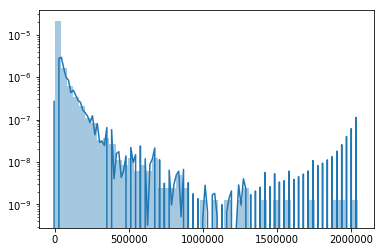

In [232]:
ax = sns.distplot(train["label"][:,1],hist_kws={'log':True})#, bins= star_bins)


/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive yl

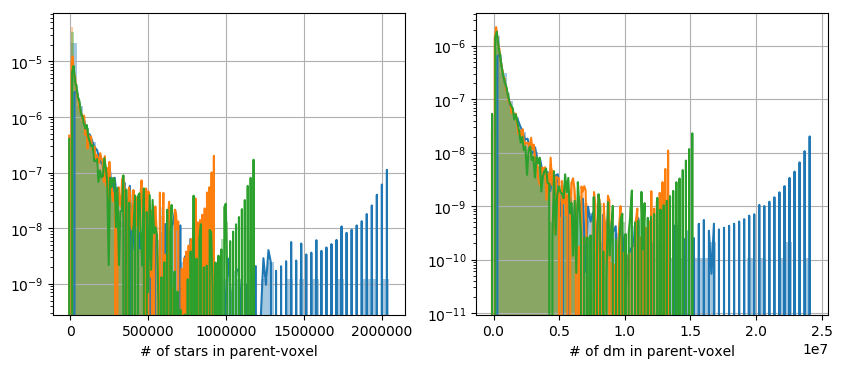

In [237]:
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(121)
sns.distplot(train["label"][:,1],hist_kws={'log':True})#, bins= star_bins)
sns.distplot(valid["label"][:,1],hist_kws={'log':True})#, bins= star_bins)
sns.distplot(test["label"][:,1],hist_kws={'log':True})#, bins= star_bins)
plt.xlabel("# of stars in parent-voxel")
plt.grid()

plt.subplot(122)
sns.distplot(train["data"][:,1],hist_kws={'log':True})
sns.distplot(valid["data"][:,1],hist_kws={'log':True})
sns.distplot(test["data"][:,1],hist_kws={'log':True})
plt.xlabel("# of dm in parent-voxel")
plt.grid()

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


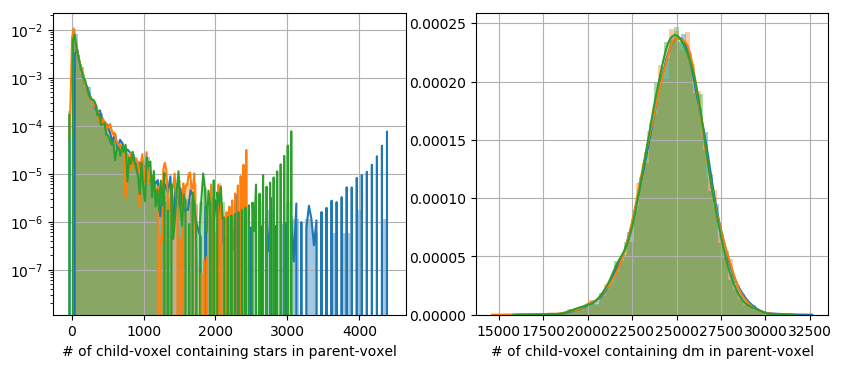

In [239]:
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(121)
sns.distplot(train["label"][:,0],hist_kws={'log':True})
sns.distplot(valid["label"][:,0],hist_kws={'log':True})
sns.distplot(test["label"][:,0],hist_kws={'log':True})
plt.xlabel("# of child-voxel containing stars in parent-voxel")
plt.grid()

plt.subplot(122)
sns.distplot(train["data"][:,0])
sns.distplot(valid["data"][:,0])
sns.distplot(test["data"][:,0])
plt.xlabel("# of child-voxel containing dm in parent-voxel")
plt.grid()

Text(0,0.5,'Mpc/h')

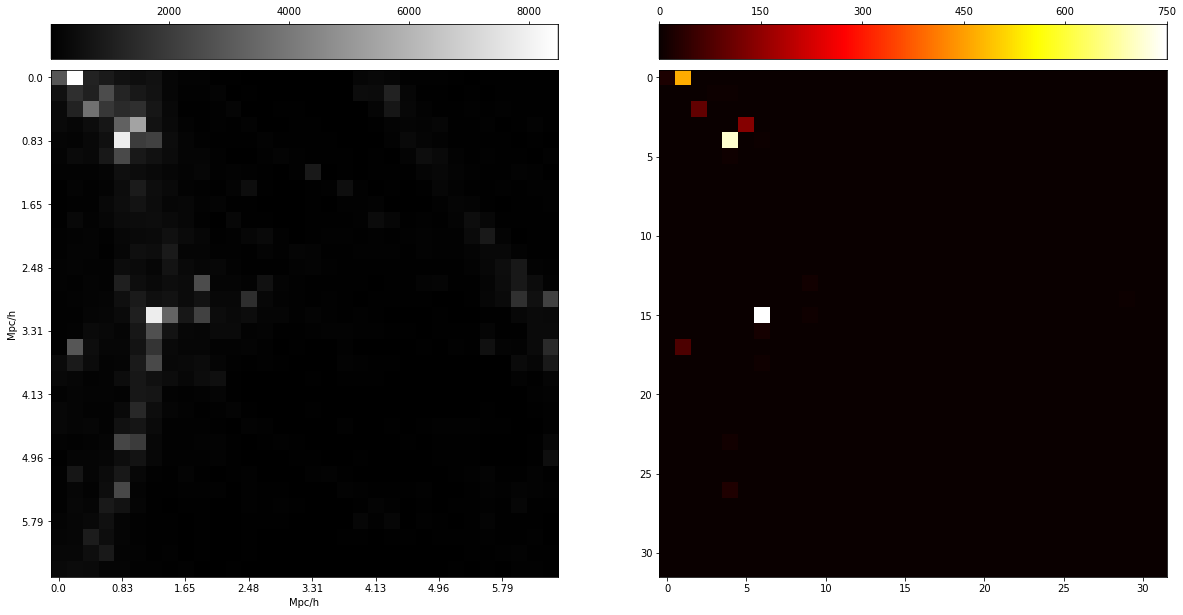

In [111]:
select_pvoxel = list(pvoxels_test_data.keys())[-1]

fig,axes = plt.subplots(1,2, figsize=(20,60))

dm_projection = np.sum(pvoxels_test_data[select_pvoxel], axis = -1)
stars_projection =  np.sum(pvoxels_test_label[select_pvoxel], axis = -1)


xlabels_pos = np.round(np.linspace(0,(sim_boxsize/n_pvoxels),32), decimals=2)
xlabels = np.arange(0,32,4)
im_0 = axes[0].imshow((dm_projection), cmap='gray')
ax_divider_0 = make_axes_locatable(axes[0])
# add an axes above the main axes.
cax_0 = ax_divider_0.append_axes("top", size="7%", pad="2%")
cb_0 = colorbar(im_0, cax=cax_0, orientation="horizontal")
# change tick position to top. Tick position defaults to bottom and overlaps
# the image.
cax_0.xaxis.set_ticks_position("top")

im_1 = axes[1].imshow((stars_projection), cmap='hot')
ax_divider_1 = make_axes_locatable(axes[1])
# add an axes above the main axes.
cax_1 = ax_divider_1.append_axes("top", size="7%", pad="2%")
cb_1 = colorbar(im_1, cax=cax_1, orientation="horizontal")
# change tick position to top. Tick position defaults to bottom and overlaps
# the image.
cax_1.xaxis.set_ticks_position("top")


axes[0].set_xticks(xlabels)
axes[0].set_xticklabels(xlabels_pos[xlabels])

axes[0].set_yticks(xlabels)
axes[0].set_yticklabels(xlabels_pos[xlabels])
#ax.set_yticks(xlabels_pos)
#ax.set_yticklabels( xlabels)
axes[0].set_xlabel('Mpc/h')
axes[0].set_ylabel('Mpc/h')


## TEST CONFUSION MATRIX FOR DIFFERENT CUTS (at voxel level)

In [252]:
# Load full data

test_dm_h5 = h5py.File(test_data_file, "r")
test_stars_h5 = h5py.File(test_label_file, "r")

test_pvoxels_dm = []
test_pvoxels_stars = []

for key in test_dm_h5.keys():
    test_pvoxels_dm.append(test_dm_h5[key][...])
    test_pvoxels_stars.append(test_stars_h5[key][...])

test_dm_h5.close()
test_stars_h5.close()

test_pvoxels_dm = np.asarray(test_pvoxels_dm)
test_pvoxels_stars = np.asarray(test_pvoxels_stars)

In [255]:
# Get rid of voxels with no dark matter

stars_true = test_pvoxels_stars.flatten() > 0


[False False False ... False False False]


In [316]:
minimum_n_dm = 500

stars_pred = test_pvoxels_dm.flatten() > minimum_n_dm


In [317]:
cm = confusion_matrix(stars_true, stars_pred)

In [318]:
TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

precision = TP / (TP + FP)
recall = TP / (TP +FN)
print(f'Precision : {precision*100:.2f} %')
print(f'Recall : {recall*100:.2f} %')

Precision : 60.33 %
Recall : 71.94 %


In [319]:
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [320]:
print(cm.sum(axis=1)[:, np.newaxis])

[[214176413]
 [   552291]]


[Text(0,0.5,'empty'), Text(0,1.5,'full')]

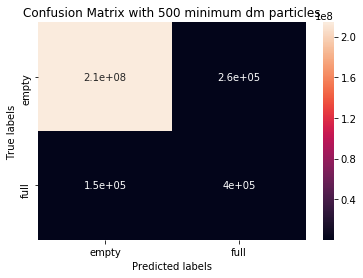

In [321]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)#annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title(f'Confusion Matrix with {minimum_n_dm} minimum dm particles')
ax.xaxis.set_ticklabels(['empty', 'full'])
ax.yaxis.set_ticklabels(['empty', 'full'])

[Text(0,0.5,'empty'), Text(0,1.5,'full')]

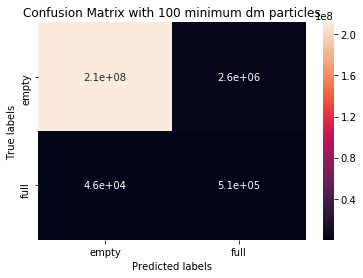

In [315]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)#annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title(f'Confusion Matrix with {minimum_n_dm} minimum dm particles')
ax.xaxis.set_ticklabels(['empty', 'full'])
ax.yaxis.set_ticklabels(['empty', 'full'])

[Text(0,0.5,'empty'), Text(0,1.5,'full')]

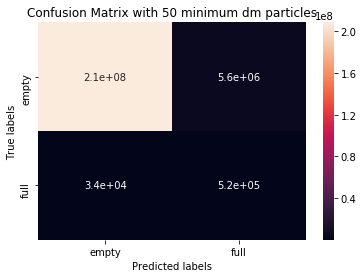

In [291]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
           #fmt='.0%'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title(f'Confusion Matrix with {minimum_n_dm} minimum dm particles')
ax.xaxis.set_ticklabels(['empty', 'full'])
ax.yaxis.set_ticklabels(['empty', 'full'])

[Text(0,0.5,'empty'), Text(0,1.5,'full')]

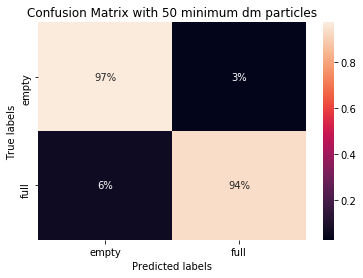

In [290]:
ax= plt.subplot()
sns.heatmap(norm_cm, annot=True, ax = ax,
           fmt='.0%'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title(f'Confusion Matrix with {minimum_n_dm} minimum dm particles')
ax.xaxis.set_ticklabels(['empty', 'full'])
ax.yaxis.set_ticklabels(['empty', 'full'])